In [67]:
set.seed(123)
getwd()
setwd("/liulab/galib/dlbcl_manuscript/")
library(rBCS)
library(tidyverse)
library(Seurat)
library(harmony)
library(viridis)
library(RColorBrewer)
library(Polychrome)
PurpleAndYellow()
library(ComplexHeatmap)
library(devtools)
library(presto)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(readxl)
source("./scripts/scplot.R")

[1] "/liulab/galib/dlbcl_manuscript"

[1] "#FF00FF" "#F400F4" "#EA00EA" "#DF00DF" "#D500D5" "#CA00CA" "#BF00BF"
 [8] "#B500B5" "#AA00AA" "#9F009F" "#950095" "#8A008A" "#800080" "#750075"
[15] "#6A006A" "#600060" "#550055" "#4A004A" "#400040" "#350035" "#2B002B"
[22] "#200020" "#150015" "#0B000B" "#000000" "#000000" "#0B0B00" "#151500"
[29] "#202000" "#2B2B00" "#353500" "#404000" "#4A4A00" "#555500" "#606000"
[36] "#6A6A00" "#757500" "#808000" "#8A8A00" "#959500" "#9F9F00" "#AAAA00"
[43] "#B5B500" "#BFBF00" "#CACA00" "#D4D400" "#DFDF00" "#EAEA00" "#F4F400"
[50] "#FFFF00"

In [69]:
B_cell<- readRDS("./data/objects/B_cell_final.rds")

In [80]:
B_cell_meta<- B_cell@meta.data
B_cell_shm_analysis<- read_xlsx('./data/sample_cluster_diversity.xlsx')  %>% filter(celltype=='bcell')
B_cell_meta$shm_key = paste0(B_cell_meta$sample_id, '_', B_cell_meta$seurat_clusters)
B_cell_shm_analysis$shm_key = paste0(B_cell_shm_analysis$id, '_', B_cell_shm_analysis$cluster)
B_cell_shm_analysis<- B_cell_shm_analysis  %>%  select(shm_key, SHM, SHM_size)
B_cell_meta<- B_cell_meta  %>% left_join(y = B_cell_shm_analysis, by = 'shm_key')
B_cell_meta$UMAP_1<- B_cell@reductions$umap@cell.embeddings[,1]
B_cell_meta$UMAP_2<- B_cell@reductions$umap@cell.embeddings[,2]

New names:
• `` -> `...1`


In [89]:
B_cell_meta$SHM  %>% table()  %>% tail()
B_cell_meta$SHM  %>% range(na.rm = TRUE)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.25)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.5)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.75)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.85)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.95)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.99)

.
6.43935483870968 6.72250000000001 8.74857142857142             8.84 
              66              173              103               35 
           10.54            12.16 
               7               82 

[1]  0.00 12.16

0%        25%        50%        75%       100% 
 0.0000000  0.0497561  0.4414706  0.9042105 12.1600000

25% 
0.0497561

50% 
0.4414706

75% 
0.9042105

85% 
1.1975

95% 
2.36

99% 
4.191667

In [91]:
B_cell_meta[!is.na(B_cell_meta$SHM) & (B_cell_meta$SHM > 6), 'SHM'] = 6

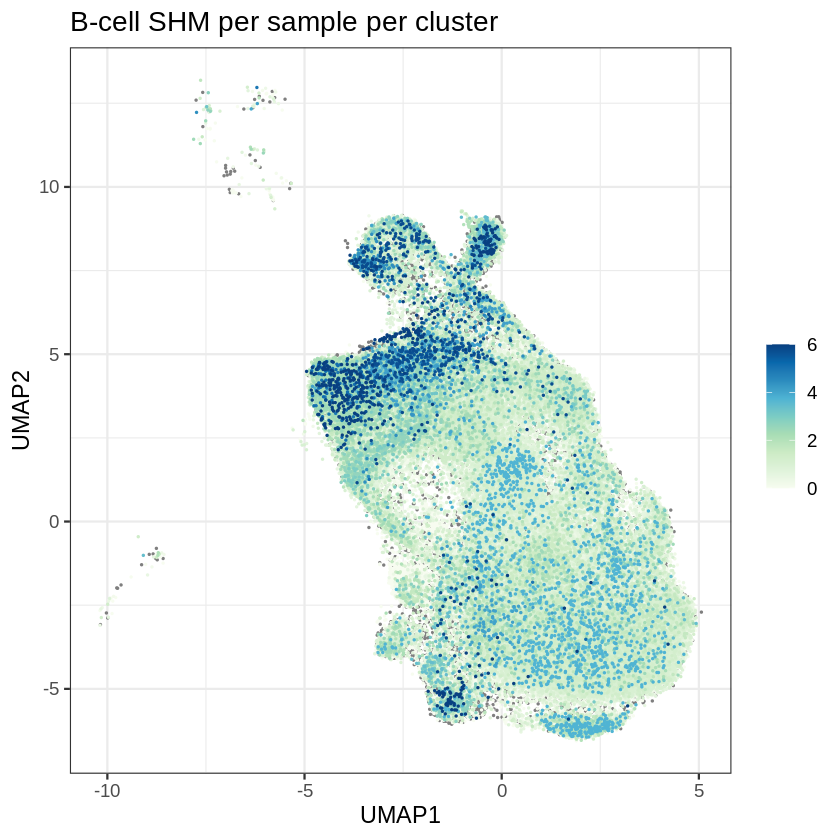

In [92]:
mycol = brewer.pal(9,"GnBu")
B_cell_meta %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    mutate(is_na= !is.na(SHM)) %>% 
    arrange(is_na, SHM)  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = SHM), size = 0.3) +
    scale_color_gradientn(colours = mycol, breaks = c(0, 2, 4, 6)) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell SHM per sample per cluster") +
    theme(legend.title=element_blank())

ggsave("./results/figures/8_B_cell_SHM.pdf", width = 12, height = 10)

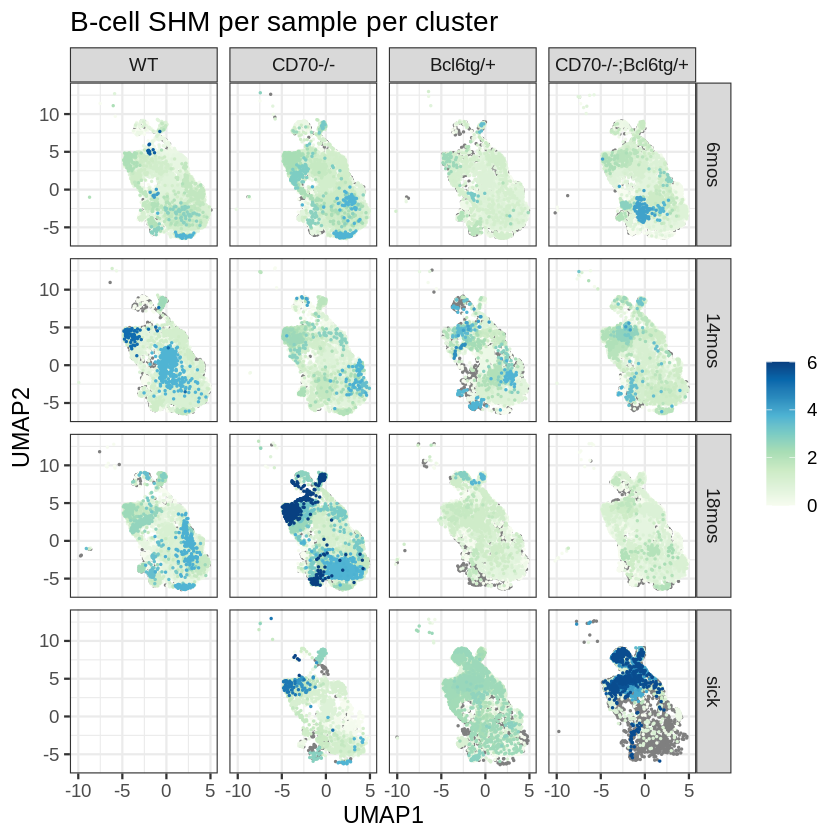

In [93]:
B_cell_meta %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    mutate(is_na= !is.na(SHM)) %>% 
    arrange(is_na, SHM)  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = SHM), size = 0.3) +
    scale_color_gradientn(colours = mycol, breaks = c(0, 2, 4, 6)) +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell SHM per sample per cluster") +
    theme(legend.title=element_blank()) +
    facet_grid(age ~ genotype)

ggsave("./results/figures/8_B_cell_SHM_by_genotype_age.pdf", width = 12, height = 10)

### Single-cell level plot

In [94]:
B_cell_meta<- B_cell@meta.data
dim(B_cell_meta)

scSHM<- read.table('./data/SHM_for_full-length-vdj.tsv', header = TRUE, sep = '\t')
colnames(scSHM) <- c('barcode', 'SHM')
dim(scSHM)

B_cell_meta$barcode<- rownames(B_cell_meta)
B_cell_meta<- B_cell_meta  %>% left_join(y = scSHM)
B_cell_meta$UMAP_1<- B_cell@reductions$umap@cell.embeddings[,1]
B_cell_meta$UMAP_2<- B_cell@reductions$umap@cell.embeddings[,2]

[1] 176583     27

[1] 27527     2

Joining, by = "barcode"


In [97]:
B_cell_meta$SHM  %>% table()  %>% tail(10)
B_cell_meta$SHM  %>% range(na.rm = TRUE)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.25)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.5)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.75)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.85)
B_cell_meta$SHM  %>% quantile(na.rm = TRUE, 0.95)

.
12.59 12.67  12.8 13.27 13.36 13.54 13.83 14.24 15.07 17.35 
    1     1     1     1     1     1     1     1     1     1 

[1]  0.00 17.35

0%   25%   50%   75%  100% 
 0.00  0.00  0.00  0.68 17.35

25% 
  0

50% 
  0

75% 
0.68

85% 
1.7

95% 
3.77

In [103]:
B_cell_meta[!is.na(B_cell_meta$SHM) & (B_cell_meta$SHM > 4), 'SHM'] = 4

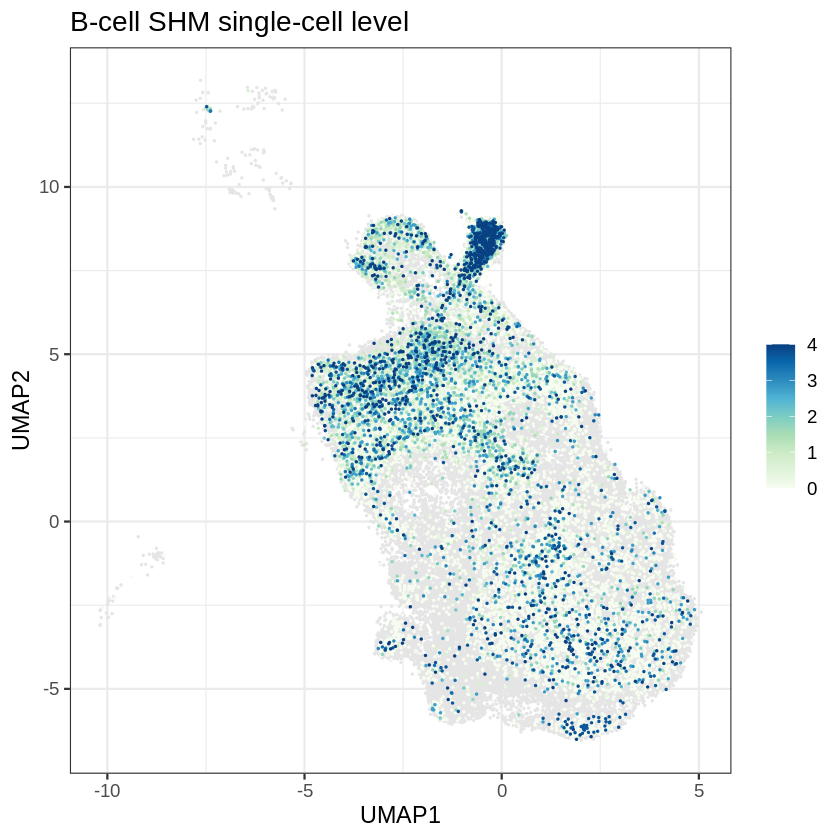

In [104]:
mycol = brewer.pal(9,"GnBu")
B_cell_meta %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    mutate(is_na= !is.na(SHM)) %>% 
    arrange(is_na, SHM)  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = SHM), size = 0.3) +
    scale_color_gradientn(colours = mycol, breaks = c(0, 1, 2, 3, 4),  na.value = "grey90") +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell SHM single-cell level") +
    theme(legend.title=element_blank())

ggsave("./results/figures/8_B_cell_SHM_single_cell_level_scale_1-4.pdf", width = 12, height = 10)

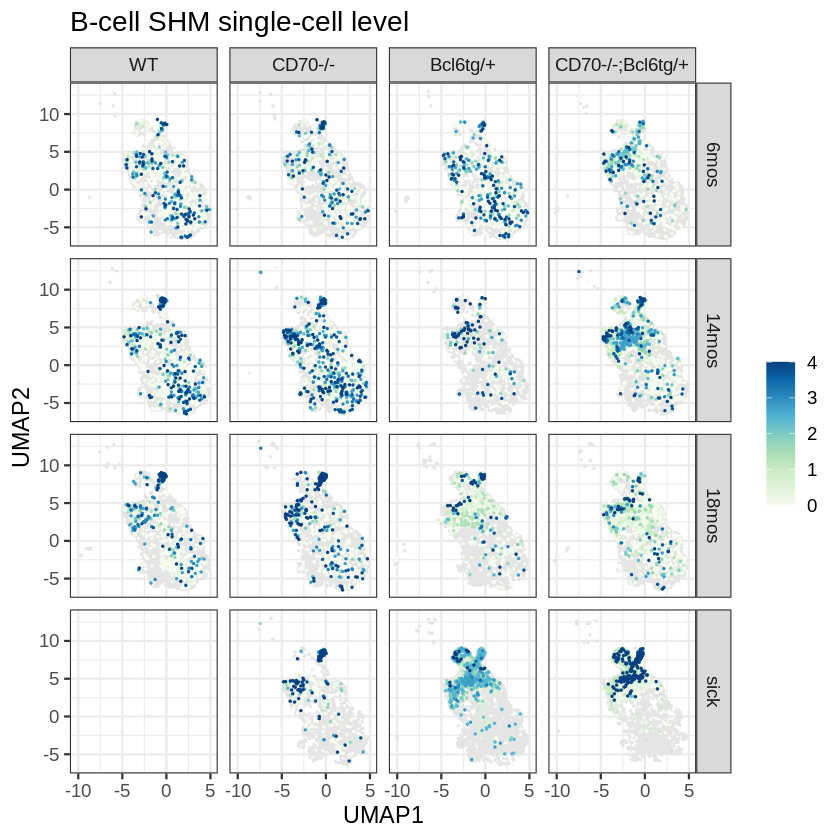

In [105]:
B_cell_meta %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    mutate(is_na= !is.na(SHM)) %>% 
    arrange(is_na, SHM)  %>%
    ggplot(aes(x = UMAP_1, y= UMAP_2)) +
    geom_point(aes(color = SHM), size = 0.3) +
    scale_color_gradientn(colours = mycol, breaks = c(0, 1, 2, 3, 4), na.value = "grey90") +
    theme_bw(base_size = 14) +
    labs(x = "UMAP1", y = "UMAP2", title = "B-cell SHM single-cell level") +
    theme(legend.title=element_blank()) +
    facet_grid(age ~ genotype)

ggsave("./results/figures/8_B_cell_SHM_by_genotype_age_single_cell_level_scale_1-4.pdf", width = 12, height = 10)